In [3]:
# =============================================================================
# IMPORTS: Libraries for ensemble learning analysis (Bagging, RF, Boosting)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (cross_validate,
                                      KFold, 
                                      train_test_split)
from sklearn.ensemble import (BaggingRegressor,
                               RandomForestRegressor, 
                               GradientBoostingRegressor)

In [4]:
# =============================================================================
# DATA LOADING: Load forest fires dataset and explore structure
# =============================================================================
FFData = pd.read_csv('forestfires.csv').dropna()
FFData.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
# =============================================================================
# DATA PREPROCESSING & BASELINE MODEL
# Prepare features/target, split data, evaluate single Decision Tree with CV
# =============================================================================
X = pd.get_dummies(FFData.drop(columns=['area']), drop_first=True)
y = FFData['area'].values
RNG = 341
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state = RNG
)

dtr = DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, random_state=RNG)

cv = KFold(n_splits=5, shuffle=True, random_state=RNG)
cv_res = cross_validate(
    dtr, X, y, cv=cv,
    scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error'),
    n_jobs=-1, return_train_score=False
)

mse_scores = -cv_res['test_neg_mean_squared_error']
rmse_scores = -cv_res['test_neg_root_mean_squared_error']

print(f"5-fold CV MSE: mean={mse_scores.mean():.4f}, std={mse_scores.std():.4f}")
print(f"5-fold CV RMSE: mean={rmse_scores.mean():.4f}, std={rmse_scores.std():.4f}")

5-fold CV MSE: mean=4947.7525, std=4029.6252
5-fold CV RMSE: mean=65.0414, std=26.7837


In [6]:
# =============================================================================
# BAGGING ENSEMBLE METHOD
# Bootstrap aggregating with Decision Trees, using Out-of-Bag samples for evaluation
# =============================================================================
from sklearn.metrics import mean_squared_error

bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=RNG),
    n_estimators=50,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=RNG
)

bag.fit(X, y)

print("Bagging OOB R^2:", bag.oob_score_)

oob_pred = bag.oob_prediction_
oob_mse = mean_squared_error(y, oob_pred)
oob_rmse = np.sqrt(oob_mse)
print(f"Bagging OOB MSE: {oob_mse:.4f}")
print(f"Bagging OOB RMSE: {oob_rmse:.4f}")

Bagging OOB R^2: -0.20584542455141297
Bagging OOB MSE: 4876.7109
Bagging OOB RMSE: 69.8335


In [7]:
# =============================================================================
# RANDOM FOREST METHOD
# Bagging + random feature selection at each split, evaluated with OOB samples
# =============================================================================
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',   
    oob_score=True,
    random_state=RNG,
    n_jobs=-1
)

rf.fit(X, y)

# OOB R^2
print("Random Forest OOB R^2:", rf.oob_score_)

# OOB predictions -> compute MSE / RMSE
oob_pred_rf = rf.oob_prediction_
oob_mse_rf = mean_squared_error(y, oob_pred_rf)
oob_rmse_rf = np.sqrt(oob_mse_rf)
print(f"Random Forest OOB MSE: {oob_mse_rf:.4f}")
print(f"Random Forest OOB RMSE: {oob_rmse_rf:.4f}")

Random Forest OOB R^2: -0.11179034172933267
Random Forest OOB MSE: 4496.3309
Random Forest OOB RMSE: 67.0547


In [8]:
# =============================================================================
# GRADIENT BOOSTING METHOD  
# Sequential ensemble where each tree learns from previous errors, uses CV evaluation
# =============================================================================
boost = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RNG
)

cv_res_boost = cross_validate(
    boost, X, y, cv=cv,
    scoring=('neg_mean_squared_error', 'neg_root_mean_squared_error'),
    n_jobs=-1, return_train_score=False
)

mse_scores_boost = -cv_res_boost['test_neg_mean_squared_error']
rmse_scores_boost = -cv_res_boost['test_neg_root_mean_squared_error']

print(f"5-fold CV (Boosting) MSE: mean={mse_scores_boost.mean():.4f}, std={mse_scores_boost.std():.4f}")
print(f"5-fold CV (Boosting) RMSE: mean={rmse_scores_boost.mean():.4f}, std={rmse_scores_boost.std():.4f}")

5-fold CV (Boosting) MSE: mean=4588.0567, std=3535.8432
5-fold CV (Boosting) RMSE: mean=62.7118, std=25.5985


In [9]:
# =============================================================================
# MODEL FACTORY FUNCTION
# Creates all three ensemble types with configurable number of trees for comparison
# =============================================================================
def get_models(num_trees):
    bag = BaggingRegressor(
       estimator=DecisionTreeRegressor(random_state=RNG),
        n_estimators=num_trees,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=RNG
    )
    rf = RandomForestRegressor(
        n_estimators=num_trees,
        max_features='sqrt',
        oob_score=True,
        random_state=RNG,
        n_jobs=-1
    )
    boost = GradientBoostingRegressor(
        n_estimators=num_trees,
        learning_rate=0.1,
        max_depth=3,
        random_state=RNG
    )
    return {"bag": bag, "rf": rf, "boost": boost}

In [10]:
# =============================================================================
# MODEL EVALUATION FUNCTION
# Standardized CV evaluation returning train/validation RMSE and R² scores
# =============================================================================
def evaluate_model(model, X, y, cv):
    # Returns average RMSE and R^2 from cross-validation.
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring=("r2", "neg_root_mean_squared_error"),
        return_train_score=True
    )
    return {
        "Train RMSE": -scores["train_neg_root_mean_squared_error"].mean(),
        "Val RMSE":   -scores["test_neg_root_mean_squared_error"].mean(),
        "Train R^2":   scores["train_r2"].mean(),
        "Val R^2":     scores["test_r2"].mean(),
    }

In [ ]:
# =============================================================================
# PERFORMANCE COMPARISON LOOP
# Test all ensemble methods across different tree counts (1, 26, 51, 76, 101)
# Collect both in-sample and out-of-sample RMSE for bias-variance analysis
# =============================================================================
bag_in, bag_out = [], []
rf_in, rf_out = [], []
boost_in, boost_out = [], []

for num_trees in range(1,101,25):
    mods = get_models(num_trees)
    # bagging results
    bag_res = evaluate_model(mods['bag'], X_train, y_train, cv)
    bag_in.append(bag_res['Train RMSE'])
    bag_out.append(bag_res['Val RMSE'])
    # rf results
    rf_res = evaluate_model(mods['rf'], X_train, y_train, cv)
    rf_in.append(rf_res['Train RMSE'])
    rf_out.append(rf_res['Val RMSE'])
    # boosting results
    boost_res = evaluate_model(mods['boost'], X_train, y_train, cv)
    boost_in.append(boost_res['Train RMSE'])
    boost_out.append(boost_res['Val RMSE'])

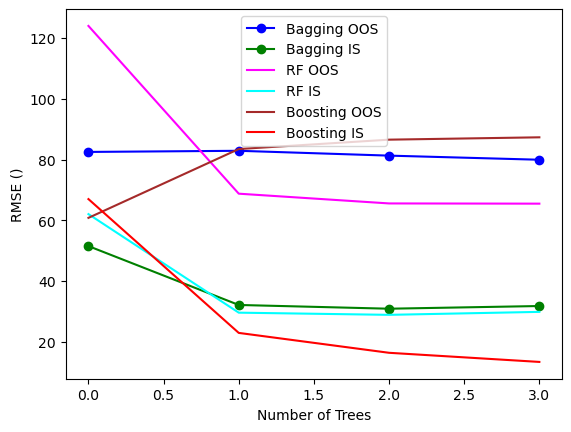

In [12]:
# =============================================================================
# PERFORMANCE VISUALIZATION
# Plot RMSE curves for all methods showing overfitting patterns (IS vs OOS)
# =============================================================================
plt.plot(bag_out, marker = 'o', color = 'blue', label = 'Bagging OOS')
plt.plot(bag_in, marker = 'o', color = 'Green', label = 'Bagging IS')
plt.plot(rf_out, color = 'magenta', label = 'RF OOS')
plt.plot(rf_in, color = 'cyan', label = 'RF IS')
plt.plot(boost_out, color = 'brown', label = 'Boosting OOS')
plt.plot(boost_in, color = 'red', label = 'Boosting IS')
plt.legend()
plt.ylabel("RMSE ()")
plt.xlabel("Number of Trees")
plt.show()